# Algoritmo Best-First Search para problemas de búsqueda

El algoritmo de Best-First Search es un algoritmo simple basado en un árbol de búsqueda. Este algoritmo toma como entrada un problema de búsqueda y construye un árbol de búsqueda a partir de este.

Para definirlo, presentaremos en primer lugar los elementos necesarios para definir nuestro problema de búsqueda.

## Problema de búsqueda (mundo de la aspiradora)

Definiremos el problema del mundo de la aspiradora, para esto recordemos que un problema de búsqueda cuenta con los siguientes elementos:

* Conjunto de estados
* Estado inicial
* Estados finales
* Acciones
* Modelo de transición
* Función de costo

In [1]:
#Paqueterías
from itertools import product
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

#### Estados

Para plantear los estados, definimos una clase para crear objetos estados que nos indique cómo se encuentra el mundo en ese estado y dónde se encuentra el agente.

In [2]:
class State(object):
    """
    Define un objeto estado que contiene:
    
    world
        información sobre el mundo
    agent_location
        posición del agente en el mundo
    """
    def __init__(self):
        self.world = None
        self.agent_location = None
        
    def __str__(self):
        #return "World state: {} - Agent location: {}".format(self.world, self.agent_location)
        return "World: {}, Loc: {}".format(self.world, self.agent_location)

En el mundo de la aspitadora, contaremos con dos cuadros. Para definir los estados indexaremos cada uno de los posibles situaciones del mundo (que uno o ambos cuadrados estén sucios o limpios, y que el agente se encuentre en uno o otro cuadrado).

La idea es indexar cada estado, de tal forma que podamos referirnos a estos estados con los índices y recueprar la descripción del estado de manera sencilla.

Los estados finales corresponderán a los estados en donde ambos cuadrados están limpios. El estado inicial podrá ser cualquier estado.

In [3]:
cuadros = ['A','B']

#Inicializa contador de estados
i = 0
#Guarda estados
states = {}
#Determina los estados de suciedad
for dirt in product([1,0],repeat=len(cuadros)):
    #Determina la posición del agente
    for agent_loc in cuadros:
        #Asigna valores al objeto estado
        state = State()
        state.world = {cuadros[j]:dirt[j] for j in range(len(cuadros))}
        state.agent_location = agent_loc
        #print(i, state)
        #Guarda el estado en diccionario
        states[i] = state
        #Aumenta el valor de i
        i += 1

In [4]:
for i,state in states.items():
    print(i, state)

0 World: {'A': 1, 'B': 1}, Loc: A
1 World: {'A': 1, 'B': 1}, Loc: B
2 World: {'A': 1, 'B': 0}, Loc: A
3 World: {'A': 1, 'B': 0}, Loc: B
4 World: {'A': 0, 'B': 1}, Loc: A
5 World: {'A': 0, 'B': 1}, Loc: B
6 World: {'A': 0, 'B': 0}, Loc: A
7 World: {'A': 0, 'B': 0}, Loc: B


Para poder recuperar el índice del estado definimos la siguiente función:

In [5]:
def return_state_idx(state):    
    """
    Regresa el índice de un estado en el diccionario de estados.
    
    Argumentos
    ----------
    state : object
        el estado del cual se quiere obtener el índice
    """
    for i, new_state in states.items():
        if state.world == new_state.world and state.agent_location == new_state.agent_location:
            return i

#### Modelo de transición

Para el modelo de transición, necesitamos definir qué es lo que hace cada acción al estado actual. Las acciones serán las mismas de siempre:

* Limpia
* Moverse a la izquierda
* Moverse a la derecha

Para definir el modelo de transición, creamos una clase. Dentro de esta clase se generan las transiciones observando en qué nuevo estado nos coloca una acción. Guardamos las transiciones para definir la función de transición.

Esta clase también recuperará el nuevo estado cuando un estado previo y una acción sean dadas.

Finalmente, incluímos aquí la función de costo, que en el caso más sencillo asigna un costo igual a 1 a toda acción.

In [6]:
class Transition(object):
    """
    Clase para obtener el modelo de transicion.
    """
    def __init__(self, cost_function = None):
        self.transitions = []
        self.cost_function = cost_function

    def get_transitions(self, states):
        """
        Genera el modelo de transición con los estados.
        Únicamente para el mundo de la aspiradora.

        Argumentos
        ----------
        states : dict
        Diccionario de estados del modelo de búsqueda
        """
        for i,prev_state in states.items():
            #Copia el estado para no modificarlo
            state = deepcopy(prev_state)
            #Guarda locación del agente
            location = state.agent_location
            #Guarda estado de la suciedad
            dirt = state.world[location]

            #Acción: si está sucio, limpia
            if dirt == 1:
                new_state = deepcopy(state)
                new_state.world[location] = 0
                clean_state = return_state_idx(new_state)
                self.transitions += [(i,'Clean',clean_state)]
            #Acción: Moverse de A a B
            if location == 'A':
                new_state = deepcopy(state)
                new_state.agent_location = 'B'
                right_state = return_state_idx(new_state)
                self.transitions += [(i,'Right',right_state)]
            #Acción: Moverse de B a A
            if location == 'B':
                new_state = deepcopy(state)
                new_state.agent_location = 'A'
                left_state = return_state_idx(new_state)
                self.transitions += [(i,'Left',left_state)]

    def transition(self, state_idx, action):
        """
        Función de transición.

        Argumentos
        ----------
        state_idx : int
            Estado actual en el que nos encontramos
        action : str
            Acción que se ejecuta en el estado

        Salida
        ------
        new_state : int
            Nuevo estado, resultado de la acción. 
            Si la acción no cambia el mundo, permanece en el mismo estado.
        """
        for (st,act,new_state) in self.transitions:
            if st == state_idx and act == action:
                return new_state
            else:
                pass
        
        return state_idx

    def cost(self, state, action, new_state):
        """
        Función de costo de la acción. En general cada acción 
        del mundo de la aspiradora cuesta 1.
        """
        if self.cost_function == None:
            return 1

    def plot_graph(self):
        """
        Función para visualizar la gráfica de las transiciones.
        """
        #Crea gráfica dirigida en networkx
        G = nx.DiGraph(directed=True)
        G = nx.from_edgelist([(e[0],e[2]) for e in self.transitions])
        
        #Funciones para plotear
        pos = nx.spring_layout(G)
        nx.draw(G, pos, labels=states, with_labels=True,node_size=1)
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='b')
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(e[0],e[2]):e[1] for e in self.transitions},
                                     font_color='red')
        plt.show()

In [7]:
#Generamos el modelo de transición
transition_model = Transition()
transition_model.get_transitions(states)

Podemos ver el modelo de transción en la forma en que las accciones nos trasladan de un estado del mundo a otro. Esto también lo podemos visualizar como una gráfica.

World: {'A': 1, 'B': 1}, Loc: A -- Clean --> World: {'A': 0, 'B': 1}, Loc: A
World: {'A': 1, 'B': 1}, Loc: A -- Right --> World: {'A': 1, 'B': 1}, Loc: B
World: {'A': 1, 'B': 1}, Loc: B -- Clean --> World: {'A': 1, 'B': 0}, Loc: B
World: {'A': 1, 'B': 1}, Loc: B -- Left --> World: {'A': 1, 'B': 1}, Loc: A
World: {'A': 1, 'B': 0}, Loc: A -- Clean --> World: {'A': 0, 'B': 0}, Loc: A
World: {'A': 1, 'B': 0}, Loc: A -- Right --> World: {'A': 1, 'B': 0}, Loc: B
World: {'A': 1, 'B': 0}, Loc: B -- Left --> World: {'A': 1, 'B': 0}, Loc: A
World: {'A': 0, 'B': 1}, Loc: A -- Right --> World: {'A': 0, 'B': 1}, Loc: B
World: {'A': 0, 'B': 1}, Loc: B -- Clean --> World: {'A': 0, 'B': 0}, Loc: B
World: {'A': 0, 'B': 1}, Loc: B -- Left --> World: {'A': 0, 'B': 1}, Loc: A
World: {'A': 0, 'B': 0}, Loc: A -- Right --> World: {'A': 0, 'B': 0}, Loc: B
World: {'A': 0, 'B': 0}, Loc: B -- Left --> World: {'A': 0, 'B': 0}, Loc: A


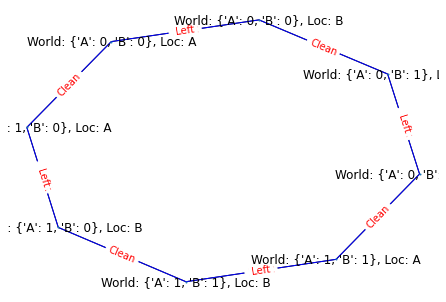

In [8]:
for (i,act,j) in transition_model.transitions:
    print("{} -- {} --> {}".format(states[i], act, states[j]))
    
transition_model.plot_graph()

### Definición del problema de búsqueda

Ya que hemos determinado los estados, y el modelo de transición, podemos crear una clase para el problema de búsqueda. Esta clase contendrá los elementos que definen a un problema de búsqueda.

In [9]:
class SearchProblem(object):
    """
    Define el problema de búsquda.
    """
    def __init__(self, states, goal, transition_model, initial=0):
        self.states = states
        self.initial = initial
        self.goal = goal
        #self.actions = actions
        self.transition_model = transition_model
        
    def actions(self,state):
        #Regresa las posibles acciones de un estado
        actions_list = []
        for transition in self.transition_model.transitions:
            if transition[0] == state:
                actions_list.append(transition[1])
        
        return actions_list
        
    def __str__(self):
        return "States: \n -{}\nInitial State:\n -{}\nFinal states:\n -{}\nTransition model:\n -{}".format(list(self.states.keys()),self.initial,self.goal,self.transition_model.transitions)
    
    def act(self,state,action):
        #Regresa la transición de una acción
        return self.transition_model.transition(state,action)

En el caso del problema en el mundo de la aspirador, los estados finales son los estados en que el mundo está limpio (estados 6 y 7), el estado inicial será elegido aleatoriamente, el modelo de transición es el que hemos definido, y las acciones son las que hemos determinado en este mundo.

In [10]:
#Definimos el problema de búsqueda
vacuum_problem = SearchProblem(states=states,goal=[6,7], initial=0,
                        transition_model=transition_model)
print(vacuum_problem)

States: 
 -[0, 1, 2, 3, 4, 5, 6, 7]
Initial State:
 -0
Final states:
 -[6, 7]
Transition model:
 -[(0, 'Clean', 4), (0, 'Right', 1), (1, 'Clean', 3), (1, 'Left', 0), (2, 'Clean', 6), (2, 'Right', 3), (3, 'Left', 2), (4, 'Right', 5), (5, 'Clean', 7), (5, 'Left', 4), (6, 'Right', 7), (7, 'Left', 6)]


In [11]:
vacuum_problem.actions(0)

['Clean', 'Right']

## Algoritmo Best-First Search

Para el algoritmo de Best-First Search definiremos una pila de prioridad que tiene la particularid, con las siguientes funciones:

* isEmpty(), determina si la pila está o no vacía.
* push(), añade un nuevo elemento a la pila.
* pop(), elimina el elemento de acuerdo a la prioridad y lo regresa.
* top(), devuelve el elemento con más alta prioridad.

In [12]:
class PriorityQueue(object):
    """
    Clase de una cola de prioridad en los problemas de búsqueda.
    """
    def __init__(self):
        self.queue = []
  
    def __str__(self):
        return ' '.join([str(q) for q in self.queue])
  
    def isEmpty(self):
        """
        Returns
        -------
        empty : bool
            Devuelve el valor True si el queue está vacío
        """
        return self.queue == []
  
    def push(self, element):
        """
        Arguments
        ---------
        element : 
            El elemento que se va agregar al queue
        """
        self.queue.append(element)
  
    def pop(self):
        """
        Elimina el elemento con más valor según un peso f
        y regresa el elemento correspondiente a este valor.
        """
        #Encuentra el elemento máximo en base al costo
        min_element = np.argmin([element.cost for element in self.queue])
        #Guarda el elemento máximo
        item = self.queue[min_element]
        #Borra este elemento de la cola
        del self.queue[min_element]
    
        return item
    
    def top(self):
        """
        Devuelve el elemento con la función de costo más alta.
        A diferencia de pop, no elimina el elemento de la pila.
        """
        #Encuentra el elemento máximo en base al costo
        min_element = np.argmin([element.cost for element in self.queue])
        #Guarda el elemento máximo
        item = self.queue[min_element]
        
        return item

Ahora debemos definir el objeto de <b>nodo</b>, el cual deberá contar con los siguientes elementos:

* state, el estado del problema de búsqueda asociado.
* parent, el nodel del que proviene.
* action, la acción que lo derivó.
* cost, el costo de llegar al nodo.

In [13]:
class Node(object):
    """
    Clase para crear nodos con sus atributos.
    """
    def __init__(self):
        self.state = 0
        self.parent = None
        self.action = None
        self.cost = 0
        
    def __str__(self):
        if self.parent == None:
            return "State: {}, Cost: {}".format(self.state,self.cost)
        else:
            return "State: {}, Action: {}, Parent: {}, Cost: {}".format(self.state,self.action,self.parent.state,self.cost)

Una vez que hemos definido los elementos con los que trabajaremos, definiremos el algoritmo de Best-First Search como una función. Para esto, también necesimaos definir una función para <b>expandir</b> cada nodo según la estructura del problema de búsqueda.

In [14]:
def expand(problem, node):
    """
    Función para expandir los nodos dado el problema.
    
    Argumentos
    ---------
    problem : objeto
        Problema de búsqueda.
    node : objeto
        Nodo que se va a expandir.
        
    Salida
    ------
    childs :generator
        Generador con los hijos del nodo.
    """
    #Nodo en el que se inicia
    s = node.state 

    for action in problem.actions(s):
        #Ejecuta la acción
        new_s = problem.act(s, action)
        #Guarda el costo de la acción
        cost = node.cost + problem.transition_model.cost(s,action,new_s)
        
        #Genera un nuevo nodo
        new_node = Node()
        new_node.state = new_s
        new_node.parent = node 
        new_node.action = action 
        new_node.cost = cost

        yield new_node

Ya con la función de expansión definida, podemos pasar a definir el algoritmo de <b>Best-First Search</b> para un problema de búsqueda.

In [15]:
def BestFirstSearch(problem):
    """
    Algoritmo Best-First Search para generar el camino más apto
    en el árbol de búsqueda de un problema.
    
    Argumentos
    ----------
    problem : objeto
        Problema de búsquda.
        
    Salida
    ------
    nodes : list
        Lista de los nodos que llevan a la solución.
    """
    #Almacenamiento de nodos
    nodes = []
    #Nodo inicial
    node = Node()
    node.state = problem.initial
    #Frontera con cola de prioridad
    frontier = PriorityQueue()
    frontier.push(node)
    #Nodos alcanzados
    reached = {problem.initial:node}

    #Mientras la frontera no esté vacía
    while frontier.isEmpty() == False:
        #Pop en frontera
        node = frontier.pop()
        #Guarda el nodo en la lista
        nodes.append(node)                        
        
        #Si llega a un nodo final se detiene 
        #y regresa el camino de nodos
        if node.state in problem.goal:
            return nodes

        #Expande el nodo actual
        for child in expand(problem, node):
            #Guarda estado de los hijos
            state = child.state
            #Guarda los hijos no alcanzados o que tengan menor costo
            if state not in reached.keys() or child.cost < reached[state].cost:
                reached[state] = child
                frontier.push(child)                    

    #Si no logra llegar a un nodo final
    #El algoritmo regresa mensaje de error
    return "No se ha logrado llegar a un estado final."

### Aplicación del algoritmo Best-First Search al problema

Hemos definido el problema de búsqueda del mundo de la aspiradora y el algoritmo de Best-First Search. Ahora podemos ver cuál es el resultado de aplicar este algoritmo a nuestro problema.

In [16]:
#Aplica el algoritmo al problema
tree = BestFirstSearch(vacuum_problem)

#Observamos el resultado del árbol
for node in tree:
    if node.parent != None:
        parent = states[node.parent.state]
    else:
        parent = '|'
    print("{} --> Action: {}, {}, cost: {}".format(parent, node.action, states[node.state], node.cost))

| --> Action: None, World: {'A': 1, 'B': 1}, Loc: A, cost: 0
World: {'A': 1, 'B': 1}, Loc: A --> Action: Clean, World: {'A': 0, 'B': 1}, Loc: A, cost: 1
World: {'A': 1, 'B': 1}, Loc: A --> Action: Right, World: {'A': 1, 'B': 1}, Loc: B, cost: 1
World: {'A': 0, 'B': 1}, Loc: A --> Action: Right, World: {'A': 0, 'B': 1}, Loc: B, cost: 2
World: {'A': 1, 'B': 1}, Loc: B --> Action: Clean, World: {'A': 1, 'B': 0}, Loc: B, cost: 2
World: {'A': 0, 'B': 1}, Loc: B --> Action: Clean, World: {'A': 0, 'B': 0}, Loc: B, cost: 3


En el algoritmo de Best-First Search hemos obtenido el árbol de búsqueda que llega hasta el estado final, pero 

In [17]:
def get_path(search_tree, root):
    """
    Recorre el árbol de búsqueda de atrás hacia el inicio para obtener el camino de acciones
    que llevaron a la meta.
    """
    #Meta
    leaf = search_tree[::-1][0]
    #Padre de la meta
    parent = leaf.parent
    #Adjunta la meta y su padre al camino
    path = [leaf, parent]
    #Recorre el árbol de búsqueda hasta el inicial
    while parent.state != root:
        parent = parent.parent
        #Adjunta los padres en el camino
        path.append(parent)
        
    return path[::-1]
    
for n in get_path(tree, vacuum_problem.initial):
    print("{} ----->\n{}".format(n.action, states[n.state]))

None ----->
World: {'A': 1, 'B': 1}, Loc: A
Clean ----->
World: {'A': 0, 'B': 1}, Loc: A
Right ----->
World: {'A': 0, 'B': 1}, Loc: B
Clean ----->
World: {'A': 0, 'B': 0}, Loc: B


En el resultado anterior, hemos iniciado a partir del estado 0, pero podemos aleatorizar el estado de inicialización para observar el comportamiento del algoritmo cuando iniciamos en diferentes estados.

In [18]:
#Definimos el problema de búsqueda
#El estado inicial es aleatorio
problem = SearchProblem(states=states,goal=[6,7], initial=random.choice(list(states.keys())),
                        transition_model=transition_model)
print(problem,'\n')

for node in BestFirstSearch(problem):
    if node.parent != None:
        parent = states[node.parent.state]
    else:
        parent = '|'
    print("{} --> Action: {}, {}, cost: {}".format(parent, node.action, states[node.state], node.cost))

States: 
 -[0, 1, 2, 3, 4, 5, 6, 7]
Initial State:
 -0
Final states:
 -[6, 7]
Transition model:
 -[(0, 'Clean', 4), (0, 'Right', 1), (1, 'Clean', 3), (1, 'Left', 0), (2, 'Clean', 6), (2, 'Right', 3), (3, 'Left', 2), (4, 'Right', 5), (5, 'Clean', 7), (5, 'Left', 4), (6, 'Right', 7), (7, 'Left', 6)] 

| --> Action: None, World: {'A': 1, 'B': 1}, Loc: A, cost: 0
World: {'A': 1, 'B': 1}, Loc: A --> Action: Clean, World: {'A': 0, 'B': 1}, Loc: A, cost: 1
World: {'A': 1, 'B': 1}, Loc: A --> Action: Right, World: {'A': 1, 'B': 1}, Loc: B, cost: 1
World: {'A': 0, 'B': 1}, Loc: A --> Action: Right, World: {'A': 0, 'B': 1}, Loc: B, cost: 2
World: {'A': 1, 'B': 1}, Loc: B --> Action: Clean, World: {'A': 1, 'B': 0}, Loc: B, cost: 2
World: {'A': 0, 'B': 1}, Loc: B --> Action: Clean, World: {'A': 0, 'B': 0}, Loc: B, cost: 3


In [19]:
for n in get_path(BestFirstSearch(problem), problem.initial):
    print("{} ----->\n{}".format(n.action, states[n.state]))

None ----->
World: {'A': 1, 'B': 1}, Loc: A
Clean ----->
World: {'A': 0, 'B': 1}, Loc: A
Right ----->
World: {'A': 0, 'B': 1}, Loc: B
Clean ----->
World: {'A': 0, 'B': 0}, Loc: B
